<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 - Character Generator Model (Problem 2)</h2><h3>AY2020/21 Semester</h3></th>
    </tr>
</table>

Objective: Develop a English Language Model RNN capable of generating semi-coherent English sentences

In [1]:
DATA_DIR = "../data"

In [2]:
# autoformat code on cell run.
%load_ext lab_black
# autoreload imported modules on change
%load_ext autoreload
%autoreload 2

# Import the Required Packages
import os
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

from git import Repo
from random import randint
from unidecode import unidecode
from minio import Minio
from pprint import pprint
from zipfile import ZipFile
from mlflow.tracking.client import MlflowClient
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import load_model
from modeling import (
    dense_classifier,
    rnn_block,
    compile_callbacks,
    build_model,
    train_eval_model,
)
from evaluate import extract_run_meta_metrics

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-c0qih4in because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Configure access to MLFlow by setting the following environment variables:
- `MLFLOW_TRACKING_URI` - URL to the MLFlow Tracking server.
- `MLFLOW_S3_ENDPOINT_URL` - URL to the MLFlow S3 Backend Store
- `MLFLOW_EXPERIMENT` - Optional. The name of the MLFlow experiment to log to.
- `MINIO_HOST` - End to the Minio S3 Store.
- `AWS_ACCESS_KEY_ID` - MLFlow S3 backend store Avectorsccess Key ID.
- `AWS_SECRET_ACCESS_KEY` - MLFlow S3 backend store secret access key.

`TF_FORCE_GPU_ALLOW_GROWTH` -  Force Tensorflow to allocate GPU memory dynamically
instead of of all at once as a workaround for this
[cuDNN failed to initialize issue](https://github.com/tensorflow/tensorflow/issues/24828).

In [3]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true


Start MLFlow run with the name of the commit as fthe run name.

In [4]:
mlflow.set_experiment(os.environ.get("MLFLOW_EXPERIMENT", "staging"))

In [5]:
repo = Repo(search_parent_directories=True)
mlflow.start_run(run_name=repo.head.commit.message)

<ActiveRun: >

Setup `minio` client.

In [6]:
minio = Minio(
    endpoint=os.environ["MINIO_HOST"],
    access_key=os.environ["AWS_ACCESS_KEY_ID"],
    secret_key=os.environ["AWS_SECRET_ACCESS_KEY"],
    secure=False,
)

## Step 1 – Data Loading and Processing

### 1.1 Data Loading

 Load the `THE ADVENTURES OF SHERLOCK HOLMES` text:

In [7]:
with open(f"{DATA_DIR}/holmes.txt") as f:
    holmes_text = f.read()

### 1.2 EDA

Take a peek at the first 5 lines:
- a unicode character `\ufeff` has to be replaced.

In [8]:
holmes_text.splitlines()[:6]

['\ufeffTHE ADVENTURES OF SHERLOCK HOLMES by SIR ARTHUR CONAN DOYLE',
 '',
 '   I. A Scandal in Bohemia',
 '  II. The Red-headed League',
 ' III. A Case of Identity',
 '  IV. The Boscombe Valley Mystery']

- No. of unique characters:

In [9]:
unique_chars = np.unique(list(holmes_text))
print(unique_chars)
# -1 for the `\ufeff` character to be removed.
n_unique_chars = len(unique_chars) - 1
print("no. of unique characters:", n_unique_chars)

['\n' ' ' '!' '"' '&' "'" '(' ')' ',' '-' '.' '/' '0' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' ':' ';' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K'
 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'a' 'b' 'c'
 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u'
 'v' 'w' 'x' 'y' 'z' 'à' 'â' 'è' 'é' '\ufeff']
no. of unique characters: 81


### 1.3 Data Preprocessing

Replace unicode characters with ASCII ones:

In [10]:
clean_holmes_text = unidecode(holmes_text)

In [11]:
clean_holmes_text.splitlines()[:6]

['THE ADVENTURES OF SHERLOCK HOLMES by SIR ARTHUR CONAN DOYLE',
 '',
 '   I. A Scandal in Bohemia',
 '  II. The Red-headed League',
 ' III. A Case of Identity',
 '  IV. The Boscombe Valley Mystery']

Compile a mapping from between a number and a character:

In [12]:
charset = {char: i for i, char in enumerate(unique_chars)}
del charset["\ufeff"]
print(dict(list(charset.items())[:6]), "...")

{'\n': 0, ' ': 1, '!': 2, '"': 3, '&': 4, "'": 5} ...


To train a character level language model that predicts the next character, text has to processed into:
- context - List of preceding characters as the context the model base its prediction on.
- character - The target prediction character given the preceding context that model is trying to predict.

In [13]:
process_params = {
    "context_len": 250,
    "charset_size": n_unique_chars,
}
mlflow.log_params(process_params)

In [14]:
def generate_context_char_idx(text, process_params):
    """Generate index for context and char for training a character level language model"""
    # calculate no. of examples: (context, char) pairs
    context_char_len = process_params["context_len"] + 1
    n_examples = len(text) - context_char_len

    ctx_positions = []
    target_char_idxs = []
    for i_example in range(n_examples):
        # collect positions of where the context substr start and ends
        context_start = i_example
        context_end = context_start + process_params["context_len"]
        ctx_positions.append((context_start, context_end))

        # collect index of target prediction char
        target_char_idxs.append(context_end)

    return ctx_positions, target_char_idxs

In [15]:
ctx_positions, target_char_idxs = generate_context_char_idx(holmes_text, process_params)

Split the generated indices into train, valid and test subsets, reserving 5000 examples for the test set, 2500 examples for the validation set:

In [16]:
n_test = 5000
n_validation = 2500

mlflow.log_param("test_size", n_test)
(
    train_valid_ctx_positions,
    test_ctx_positions,
    train_valid_char_idxs,
    test_char_idxs,
) = train_test_split(ctx_positions, target_char_idxs, test_size=n_test)
(
    train_ctx_positions,
    valid_ctx_positions,
    train_char_idxs,
    valid_char_idxs,
) = train_test_split(
    train_valid_ctx_positions, train_valid_char_idxs, test_size=n_validation
)

Use a Keras `Sequence` process at model runtime:
- Extract the context and the target char  is computationally inexpensive, so the performance overhead should be minimal.
- Since there is a significant amount of overlap between context characters, preprocessing the data now will result significant redundant RAM  usage.

In [17]:
class TextContext(Sequence):
    def __init__(
        self, ctx_positions, char_idxs, text, batch_size, charset, process_params
    ):
        """
        Create a text context data sequence useful for character level language models.

        Args:
            ctx_positions: List of positions of context in the text.
            char_idxs: List of index of target predictio characters in the text.
            text: Text to generate from.
            batch_size: Size of the batchs of data to generate.
            charset: Dictionary mapping character to int used to encode words as ints.
            process_params: Additional Data processing parameters.
        """
        self.ctx_positions = ctx_positions
        self.char_idxs = char_idxs
        assert len(ctx_positions) == len(char_idxs)

        self.text = text
        self.batch_size = batch_size
        self.charset = charset
        self.params = process_params

    @property
    def context_shape(self):
        """Return the shape of the processed context vector"""
        return (self.params["context_len"], self.params["charset_size"])

    def __len__(self):
        # no. of examples: (context, char) pairs
        return len(self.ctx_positions) // self.batch_size

    def __getitem__(self, batch_idx):
        """Process text context data for the given batch at index batch_idx"""
        contexts = []
        target_chars = []

        ctx_positions_batch = self.ctx_positions[
            batch_idx * self.batch_size : (batch_idx + 1) * self.batch_size
        ]
        char_idxs_batch = self.char_idxs[
            batch_idx * self.batch_size : (batch_idx + 1) * self.batch_size
        ]

        for context_pos, target_char_idx in zip(ctx_positions_batch, char_idxs_batch):

            context_start, context_end = context_pos
            # extract context vector
            context = self.text[context_start:context_end]
            context_int = [self.charset[c] for c in context]
            contexts.append(context_int)

            # extract target char
            target_char = self.text[target_char_idx]
            target_chars.append(self.charset[target_char])

        n_classes = self.params["charset_size"]
        return (
            to_categorical(contexts, num_classes=n_classes),
            to_categorical(target_chars, num_classes=n_classes),
        )

In [18]:
train_holmes_ctx = TextContext(
    ctx_positions=train_ctx_positions,
    char_idxs=train_char_idxs,
    batch_size=512,
    text=clean_holmes_text,
    charset=charset,
    process_params=process_params,
)

In [19]:
%%timeit
train_holmes_ctx.__getitem__(0)

26.2 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
train_holmes_ctx.__getitem__(0)[0].shape

(512, 250, 81)

## Step 2 – Develop Character Generator Model

### Building the Model

In [21]:
build_model(
    input_shape=train_holmes_ctx.context_shape,
    n_classes=process_params["charset_size"],
    rnn_bidirectional=True,
).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 81)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 128)          74752     
_________________________________________________________________
layer_normalization (LayerNo (None, 250, 128)          256       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 250, 128)          98816     
_________________________________________________________________
layer_normalization_1 (Layer (None, 250, 128)          256       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
layer_normalization_2 (Layer (None, 128)               256   

### Train the Model

In [22]:
batch_size = 512

train_holmes_ctx = TextContext(
    ctx_positions=train_ctx_positions,
    char_idxs=train_char_idxs,
    batch_size=batch_size,
    text=clean_holmes_text,
    charset=charset,
    process_params=process_params,
)

valid_holmes_ctx = TextContext(
    ctx_positions=valid_ctx_positions,
    char_idxs=valid_char_idxs,
    batch_size=batch_size,
    text=clean_holmes_text,
    charset=charset,
    process_params=process_params,
)

test_holmes_ctx = TextContext(
    ctx_positions=test_ctx_positions,
    char_idxs=test_char_idxs,
    batch_size=batch_size,
    text=clean_holmes_text,
    charset=charset,
    process_params=process_params,
)

In [23]:
# train on multiple GPUs
multi_gpu =  tf.distribute.MirroredStrategy(
    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()
)

with multi_gpu.scope():
    model = train_eval_model(
        train_data=[train_holmes_ctx],
        validation_data=valid_holmes_ctx,
        test_data=[test_holmes_ctx],
        build_model_fn=build_model,
        n_classes=n_unique_chars,
        tags={
            "project": "dl-assign-2",
            "part": "1",
            "model": "sentiment",
        },
        input_shape=train_holmes_ctx.context_shape,
        git_repo=Repo(search_parent_directories=True),
        run_name=None,
        epochs=30,
        lr=1e-4,
        optimizer="adam",
        sgd_momentum=0.9,
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
        ],
        reduce_lr_stuck=False,
        reduce_lr_patience=5,
        reduce_lr_factor=0.5,
        batch_size=batch_size,
        dropout_prob=0,
        l2_reg=None,
        rnn_cell="gru",
        n_rnn_units=128,
        n_rnn_layers=2,
        rnn_bidirectional=False,
        rnn_activation="tanh",
        use_layer_norm=True,
        n_dense_units=0,
        use_batch_norm=True,
        dense_activation="relu",
    )
mlflow.end_run()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1083 steps, validate for 4 steps
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce

### Recommend the Best Model

`train_eval_model()` both trains model and evaluates the model on the test set:
```python
    # excerpt from train_eval_model() source.
    # evaluate model
    test_metrics = model.evaluate(*test_data, verbose=2)
```
The source code for `train_eval_model()` can be found [hosted here](https://github.com/mrzzy/np-dl-assign-2/blob/master/notebooks/modeling.py#L187)

In [24]:
float_cols = [
    "loss",
    "dropout_prob",
    "n_classes",
    "n_rnn_units",
    "n_dense_units",
    "learning_rate",
    "fit_epochs",
    "batch_size",
    "accuracy",
    "val_accuracy",
    "val_loss",
    "test_loss",
    "test_accuracy",
]
run_df, metrics_df = extract_run_meta_metrics(
    experiment="np-dl-2-p2-textgen",
    float_cols=float_cols,
)

In [25]:
run_df.head()

,artifact_uri,time_ms,status,context_len,charset_size,test_size,n_classes,input_shape,dropout_prob,l2_reg,...,mlflow.log-model.history,val_loss,val_accuracy,accuracy,test_loss,test_accuracy,reduce_lr_factor,reduce_lr_patience,lr,validation_split
run_id,,,,,,,,,,,,,,,,,,,,,
1f1bed614ed4407bb98891e214790152,s3://mlflow/12/1f1bed614ed4407bb98891e21479015...,9147817,FINISHED,250,81,5000,81.0,"(250, 81)",0.0,None,...,"[{""run_id"": ""1f1bed614ed4407bb98891e214790152""...",1.414153,0.571289,0.581339,1.436113,0.573785,NaN,NaN,NaN,NaN
70fdd49818674378b90383fe69daca5e,s3://mlflow/12/70fdd49818674378b90383fe69daca5...,9236808,FINISHED,250,81,5000,81.0,"(250, 81)",0.0,None,...,"[{""run_id"": ""70fdd49818674378b90383fe69daca5e""...",3.106232,0.163086,0.168456,3.106003,0.165148,0.5,5,0.001875,NaN
e78c1ad56f9f4c3b9d8b7c68c19cece5,s3://mlflow/12/e78c1ad56f9f4c3b9d8b7c68c19cece...,3092719,FINISHED,500,81,5000,81.0,"(500, 81)",0.0,None,...,"[{""run_id"": ""e78c1ad56f9f4c3b9d8b7c68c19cece5""...",1.334299,0.591797,0.601671,1.350640,0.584717,0.5,5,0.030000,NaN
4b0d5b09db5e40f7866c010b81236e55,s3://mlflow/12/4b0d5b09db5e40f7866c010b81236e5...,8475121,FINISHED,250,81,5000,81.0,"(250, 81)",0.0,None,...,"[{""run_id"": ""4b0d5b09db5e40f7866c010b81236e55""...",1.362107,0.597656,0.677451,1.341882,0.608290,NaN,NaN,NaN,NaN
4a856a18f1a6490dbb10997882e2965b,s3://mlflow/12/4a856a18f1a6490dbb10997882e2965...,5938014,FINISHED,100,81,5000,81.0,"(100, 81)",0.0,None,...,"[{""run_id"": ""4a856a18f1a6490dbb10997882e2965b""...",1.434361,0.572266,0.594424,1.433213,0.560764,0.5,10,0.010000,NaN


Evaluate the top model by lowest test loss:

In [26]:
top_model_id = run_df["test_loss"].idxmin()
top_model_metrics_df = metrics_df[metrics_df["run_id"] == top_model_id]
print(f"Top Validation Loss: {run_df.loc[top_model_id]['test_loss']}")
print(f"Top Validation Accuracy: {run_df.loc[top_model_id]['test_accuracy']}")

Top Validation Loss: 1.3418815003501
Top Validation Accuracy: 0.608289957046509


<AxesSubplot:title={'center':'Loss'}, xlabel='step', ylabel='value'>

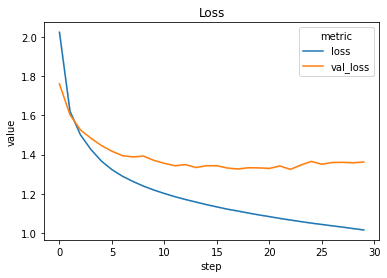

In [27]:
plt.title("Loss")
sns.lineplot(
    data=top_model_metrics_df[
        top_model_metrics_df["metric"].isin(
            [
                "val_loss",
                "loss",
            ]
        )
    ],
    x="step",
    y="value",
    hue="metric",
)

<AxesSubplot:title={'center':'Accuracy'}, xlabel='step', ylabel='value'>

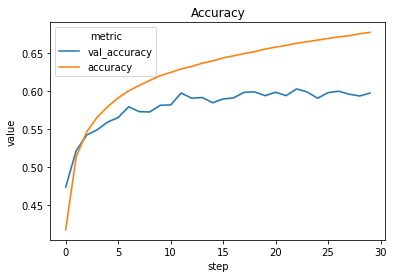

In [28]:
plt.title("Accuracy")
sns.lineplot(
    data=top_model_metrics_df[
        top_model_metrics_df["metric"].isin(
            [
                "val_accuracy",
                "accuracy",
            ]
        )
    ],
    x="step",
    y="value",
    hue="metric",
)

Retrieve model weights of top model:

In [29]:
mlflow_cli = MlflowClient()
MODELS_DIR = os.path.join(os.getcwd(), "../models")
os.makedirs(MODELS_DIR, exist_ok=True)

In [30]:
%%time
model_path = mlflow_cli.download_artifacts(
    run_id=top_model_id, path="models/data/model.h5"
)
top_model = load_model(model_path)

CPU times: user 533 ms, sys: 15.6 ms, total: 549 ms
Wall time: 558 ms


# Step 3 – Use the Best Model to generate the characters / sentences

In [31]:
def sample(preds, temperature=1.0):
    """
    Use to draw a temperature  weighted character from the given model probablities
    Low tempretures stick to the model's prediction while higher tempra
    """
    preds = np.asarray(preds).astype("float64")
    preds = (
        np.log(preds) / temperature
    )  # take a log function and then divided by temperature
    exp_preds = np.exp(preds)  # take a exp function
    preds = exp_preds / np.sum(exp_preds)  # normalize to 1
    probas = np.random.multinomial(
        1, preds, 1
    )  # roll a dice based on the probability distribution in preds
    return np.argmax(probas)  # return to the selected "next character"

Generate  text using top mode at various temperatures:

In [32]:
def generate_text(
    model, text_len=400, temperature=1.0, process_params=process_params, charset=charset
):
    n_classes = len(charset)
    reverse_charset = {int_c: char for char, int_c in charset.items()}
    # use random seed context from text
    seed_start = randint(0, len(holmes_text) - process_params["context_len"] - 1)
    context = holmes_text[seed_start : seed_start + process_params["context_len"]]
    gentext = f"{context}"

    for i in range(text_len):
        context_one_hot = np.expand_dims(
            to_categorical([charset[c] for c in context], num_classes=n_classes),
            axis=0,
        )
        preds = model.predict([context_one_hot])[0]
        pred_idx = sample(preds, temperature=temperature)
        pred_char = reverse_charset[pred_idx]
        # add predicted chart to context and generated text
        gentext += pred_char
        context += pred_char
        # remove first char in context to kept it at context_len
        context = context[1:]

    return gentext

In [33]:
%%time
print(generate_text(top_model, temperature=0.2, text_len=400))

ling, 'it was you, then. I thought that it
must be when I saw the door open.'

"'Oh, I am so frightened!' I panted.

"'My dear young lady! my dear young lady!'--you cannot think how
caressing and soothing his manner was--'and what has frightened
you, and that it was a singular consulting. I think that I was
all that it was a man of the reason which was a singular and to
see her bearing the stairs that the strange and think of the
contents was to be a single of the window of the strange and was
all in the corner of the room and the contents of the corner of
the corner of the window, and the room was a considerable stable
sent and the corner of
CPU times: user 25.3 s, sys: 0 ns, total: 25.3 s
Wall time: 25.9 s


In [34]:
%%time
print(generate_text(top_model, temperature=0.5, text_len=400))



"Not I."

"It is half-past ten now."

"Yes, and I have no doubt that is her ring."

"It may turn out to be of more interest than you think. You
remember that the affair of the blue carbuncle, which appeared to
be a mere whim at first, developed into the clast and walked all
for some of the world to the reat for him that it was a cold since
and so considerably in the same position of a pale and but he was
extraordinates, would in the stairs and the rest of a case of
the corner of the whole time in the room which I was a cab of
a particulate man, and that it was the bed back and a fact of
the window, and which it is correct in the windows. He
CPU times: user 25.2 s, sys: 0 ns, total: 25.2 s
Wall time: 26.1 s


In [35]:
%%time
print(generate_text(top_model, temperature=1.0, text_len=400))

I
could gather together that I was able to avert another public
exposure. He had no friends at all save the wandering gipsies,
and he would give these vagabonds leave to encamp upon the few
acres of bramble-covered land which represent the family estity
luggers glade. "Fine was made upon the selecting. Then he started
of its small steps--I atracted to retir?'

"'D'1le's back to me, Jones should not income. From none was no
offermatial,' perhaps, but I could explain his chin, dire!

"'What," said Holmes, still explaining up and offered, which I hardly
need the entames of colient, at all peors of this notices, which a
black hurried up, and no g
CPU times: user 25.4 s, sys: 0 ns, total: 25.4 s
Wall time: 26.1 s


In [36]:
%%time
print(generate_text(top_model, temperature=1.2, text_len=400))

h you.'

"Well, I did what she said, Mr. Holmes, and I carried the bird
all the way to Kilburn. I told my pal what I had done, for he was
a man that it was easy to tell a thing like that to. He laughed
until he choked, and we got a knife and opened the sunking."

It kept up an all through all. My gaues was prograng, but one of
the Jognes waiting from Cith's rise. She side not the deedlicy of
pars of observing Arms among the othorushs of Moran, and into the
edge; and why is clear to the address induction to scuting-robber,
errevel-to her.'" ope, my curritult is Miss Hatty Archer; for you
a look of that's an read me emplore. 'I come, as I've we
CPU times: user 25.1 s, sys: 0 ns, total: 25.1 s
Wall time: 25.7 s


In [37]:
%%time
print(generate_text(top_model, temperature=1.5, text_len=400))

ad, I believe, been
intensified by his long residence in the tropics. A series of
disgraceful brawls took place, two of which ended in the
police-court, until at last he became the terror of the village,
and the folks would fly at his approach, for his end. To themeris
quary 1000 pound."

Mr. Bechessal masstietie catched to him no confedher
moth; jerki's kity. Any universten,' says not joking back
through moidscy after Swandam in Endylons Hear, plave. I gurd,
this sums of power, and ! twit
me a circle. My orgorn's keyhored of SConly.'

"'Pray hen, so McCast up BaS PerFgulton 7sl equoredm quarters behind,
to-rushes with you. Pray as shirt upon
CPU times: user 25.1 s, sys: 0 ns, total: 25.1 s
Wall time: 26.1 s
